# Defines and general functions

In [10]:
import os
import time
import sys
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
import pathlib
import matplotlib.pyplot as plt


def print_status(message : str):
    print("[Status]: ",message)

def print_info(message : str):
    print("[Info]: ",message)

# Defining and loading the dataset

[Status]:  Defining dataset directory
[Info]:  dataset_dir set to: ../getimages/imgs/
[Info]:  num of images: 4936
[Status]:  Loading dataset images
[Info]:  Images have dims: [120, 160]
[Status]:  Creating dataset from images


Found 4936 files belonging to 4 classes.
Using 3949 files for training.
Found 4936 files belonging to 4 classes.
Using 987 files for validation.
[Info]:  Class names found: ['cross', 'flat', 'penta', 'square']
[Status]:  Visualizing dataset


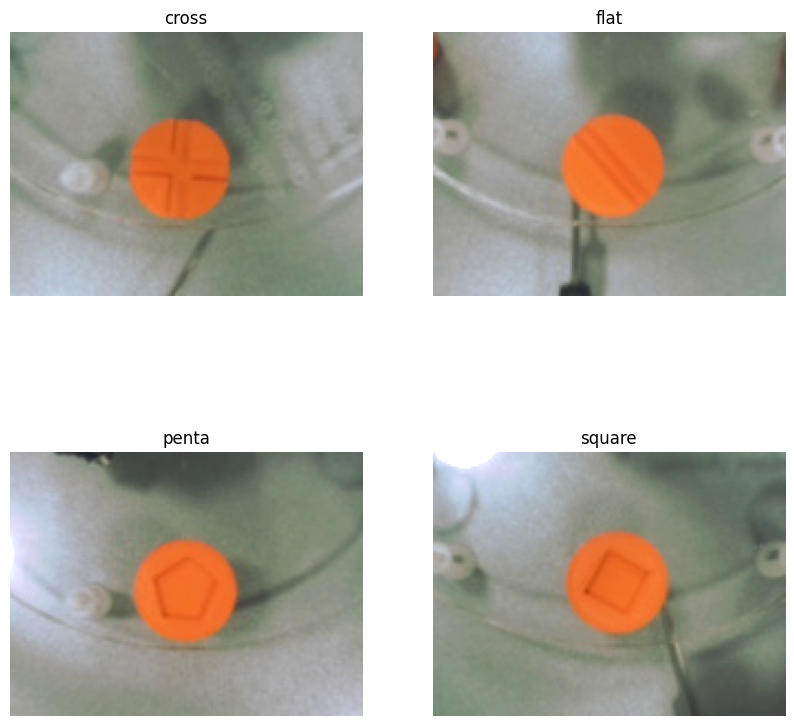

[Info]:  One traning data batch has image shape (128, 120, 160, 3)
[Info]:  One traning data batch has label shape (128,)


In [11]:
print_status("Defining dataset directory")
args = sys.argv[1:]
USE_DEFAULT_IMAGEPATH = True
if USE_DEFAULT_IMAGEPATH:
    dataset_dir = "../getimages/imgs/"
else:
    if len(args) == 2 and args[0] == '-image_path':
        dataset_dir = str(args[1])	
    else:
        dataset_dir = input("Write path to images:")
print_info(f"dataset_dir set to: {dataset_dir}")
data_dir = pathlib.Path(dataset_dir).with_suffix('')
image_count = len(list(data_dir.glob('*/*.png')))
print_info(f"num of images: {image_count}")

print_status("Loading dataset images")

image_types = ["cross", "flat", "penta", "square"]
image_files = {}
image_dims = []
for type in image_types:
    image_files[type] = list(data_dir.glob(type + '/*'))
for type in image_types:
    image = PIL.Image.open(str(image_files[type][0]))
    if image_dims != []:
        assert [image.height, image.width] == image_dims, f"Image types does not have the same dimensions!\n {type} has {[image.height, image.width]}, others have {image_dims}"
    else:
        image_dims = [image.height, image.width] 
    # image.show()

# input("Press the <ENTER> key to continue...")

print_info(f"Images have dims: {image_dims}")
print_status("Creating dataset from images")

batch_size = 128
train_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=123,
image_size=image_dims,
batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=image_dims,
batch_size=batch_size)

class_names = train_ds.class_names
print_info(f"Class names found: {class_names}")

print_status("Visualizing dataset")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    # print(labels)
    used = []
    subplot_dims = int(np.ceil(np.sqrt(len(class_names))))
    for i, label in enumerate(labels[:-1]):
        # print(i, labels[i].numpy().astype("uint8"))
        if labels[i].numpy().astype("uint8") not in used:
            ax = plt.subplot(subplot_dims, subplot_dims, labels[i].numpy().astype("uint8") + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            used.append(labels[i].numpy().astype("uint8"))
plt.show()


for image_batch, labels_batch in train_ds:
    print_info(f"One traning data batch has image shape {image_batch.shape}")
    print_info(f"One traning data batch has label shape {labels_batch.shape}")
    break


# Optimization of dataset

In [12]:

print_status("Normalizing RGB values from [0, 255] to [0, 1]")
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print_info(f"Example result: {np.min(first_image), np.max(first_image)}")

print_status("Enabling caching and prefetching of dataset for traning and validation")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

[Status]:  Normalizing RGB values from [0, 255] to [0, 1]
[Info]:  Example result: (0.039215688, 1.0)
[Status]:  Enabling caching and prefetching of dataset for traning and validation


# Either load or create model

In [13]:
LOAD_EXISTING_MODEL = False

## Create model

### Add data augmentation to ramdomly rotate, flip and zoom images

In [14]:
data_augmentation = keras.Sequential(
    [
    keras.layers.RandomFlip("horizontal",
                        input_shape=(image_dims[0],
                                    image_dims[1],
                                    3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    ]
)

#### Show example

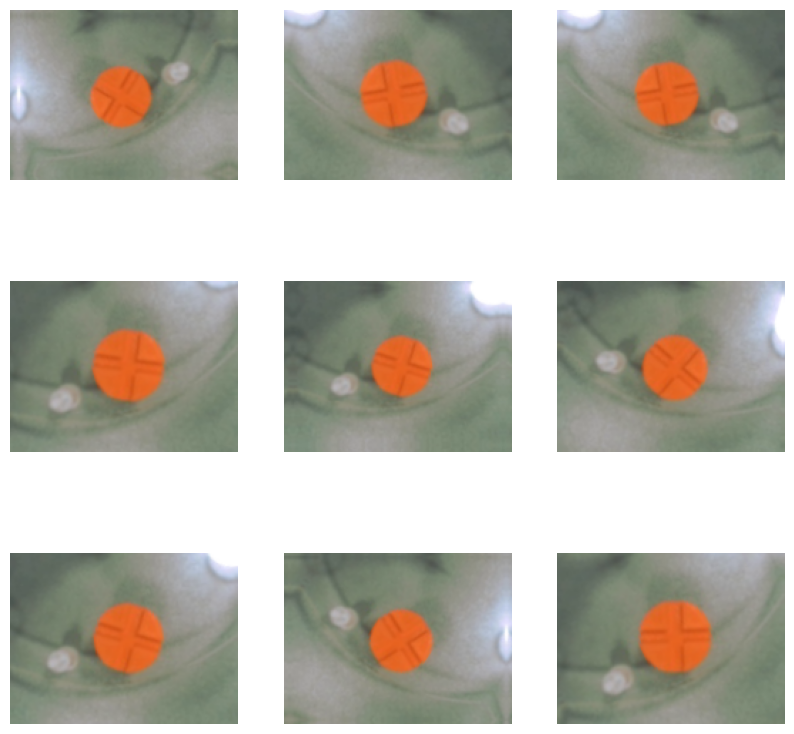

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model definition

In [16]:
if not LOAD_EXISTING_MODEL:
    print_status("Defining model")

    num_classes = len(class_names)

    model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(num_classes)
    ])

    print_status("Configuring model")

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

[Status]:  Defining model
[Status]:  Configuring model


### Model fitting

In [17]:
if not LOAD_EXISTING_MODEL:
    total_epochs = 0

In [18]:
if not LOAD_EXISTING_MODEL:
    epochs = 20
    print_status("Fitting model")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )
    total_epochs += epochs

    # input("Press the <ENTER> key to close the program...")


[Status]:  Fitting model
Epoch 1/20


31/31 [==============================] - 51s 2s/step - loss: 1.3868 - accuracy: 0.2639 - val_loss: 1.3852 - val_accuracy: 0.2817
Epoch 2/20
31/31 [==============================] - 47s 2s/step - loss: 1.3854 - accuracy: 0.2702 - val_loss: 1.3845 - val_accuracy: 0.2817
Epoch 3/20
31/31 [==============================] - 48s 2s/step - loss: 1.3851 - accuracy: 0.2702 - val_loss: 1.3846 - val_accuracy: 0.2817
Epoch 4/20
31/31 [==============================] - 45s 1s/step - loss: 1.3844 - accuracy: 0.2702 - val_loss: 1.3820 - val_accuracy: 0.2847
Epoch 5/20
31/31 [==============================] - 43s 1s/step - loss: 1.3839 - accuracy: 0.2722 - val_loss: 1.3773 - val_accuracy: 0.2746
Epoch 6/20
31/31 [==============================] - 37s 1s/step - loss: 1.3787 - accuracy: 0.2851 - val_loss: 1.3615 - val_accuracy: 0.3141
Epoch 7/20
31/31 [==============================] - 47s 2s/step - loss: 1.3696 - accuracy: 0.2963 - val_loss: 1.3094 - val_accuracy: 0.3708
Epoch 8/20
31/31 [=============

### Summarise model

In [19]:
if not LOAD_EXISTING_MODEL:
    model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 120, 160, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 120, 160, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 118, 158, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 59, 79, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 57, 77, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 28, 38, 32)        0         
 g2D)                                                 

### Show training history

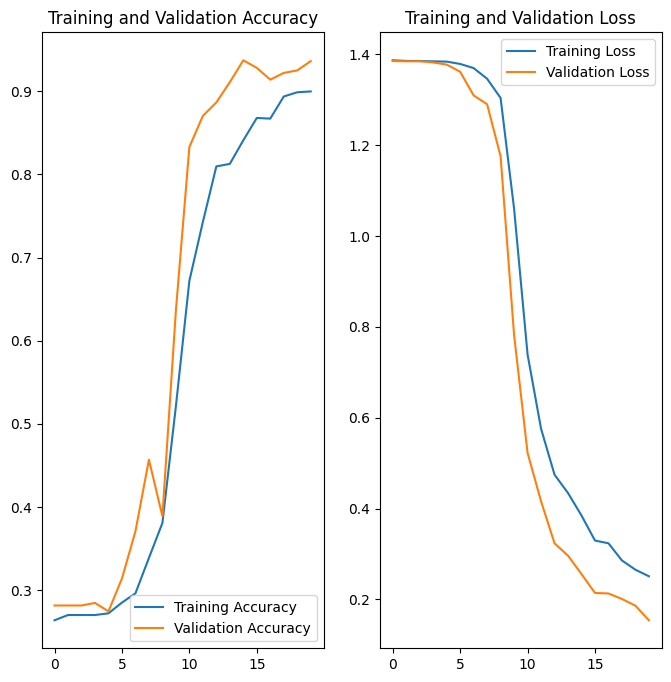

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Load model

In [21]:
if LOAD_EXISTING_MODEL:
    new_model = tf.keras.models.load_model('my_model.keras')

    # Show the model architecture
    new_model.summary()

In [22]:
# Evaluate the restored model
if LOAD_EXISTING_MODEL:
    loss, acc = new_model.evaluate(val_ds, verbose=2)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print(new_model.predict(val_ds).shape)

### Set model to loaded model

In [23]:
if LOAD_EXISTING_MODEL:
    model = new_model

# Evaluating model

In [24]:
print_status("Evaluating model")
train_loss, train_acc = model.evaluate(train_ds, verbose=2)

print_info(f"Accuracy on training data: {train_acc}")

val_loss, val_acc = model.evaluate(val_ds, verbose=2)

print_info(f"Accuracy on validation data: {val_acc}")

[Status]:  Evaluating model


31/31 - 8s - loss: 0.1513 - accuracy: 0.9443 - 8s/epoch - 254ms/step
[Info]:  Accuracy on training data: 0.9442896842956543
8/8 - 2s - loss: 0.1542 - accuracy: 0.9362 - 2s/epoch - 249ms/step
[Info]:  Accuracy on validation data: 0.936170220375061


# Testing inference

In [25]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(val_ds)
predictions.shape

8/8 [==============================] - 2s 242ms/step


(987, 4)

In [26]:
predictions[0]
prediction_class = np.argmax(predictions[0])
class_names[prediction_class]

'penta'

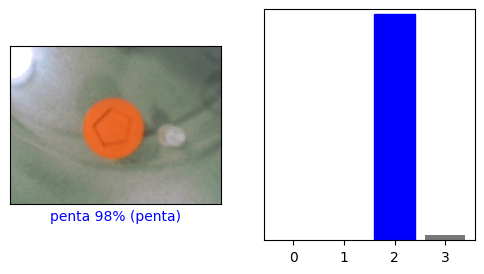

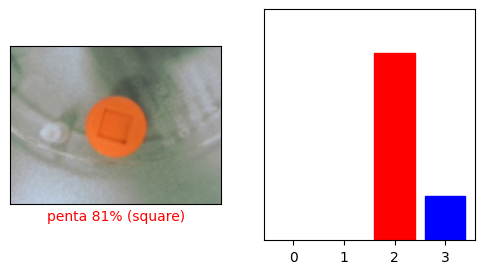

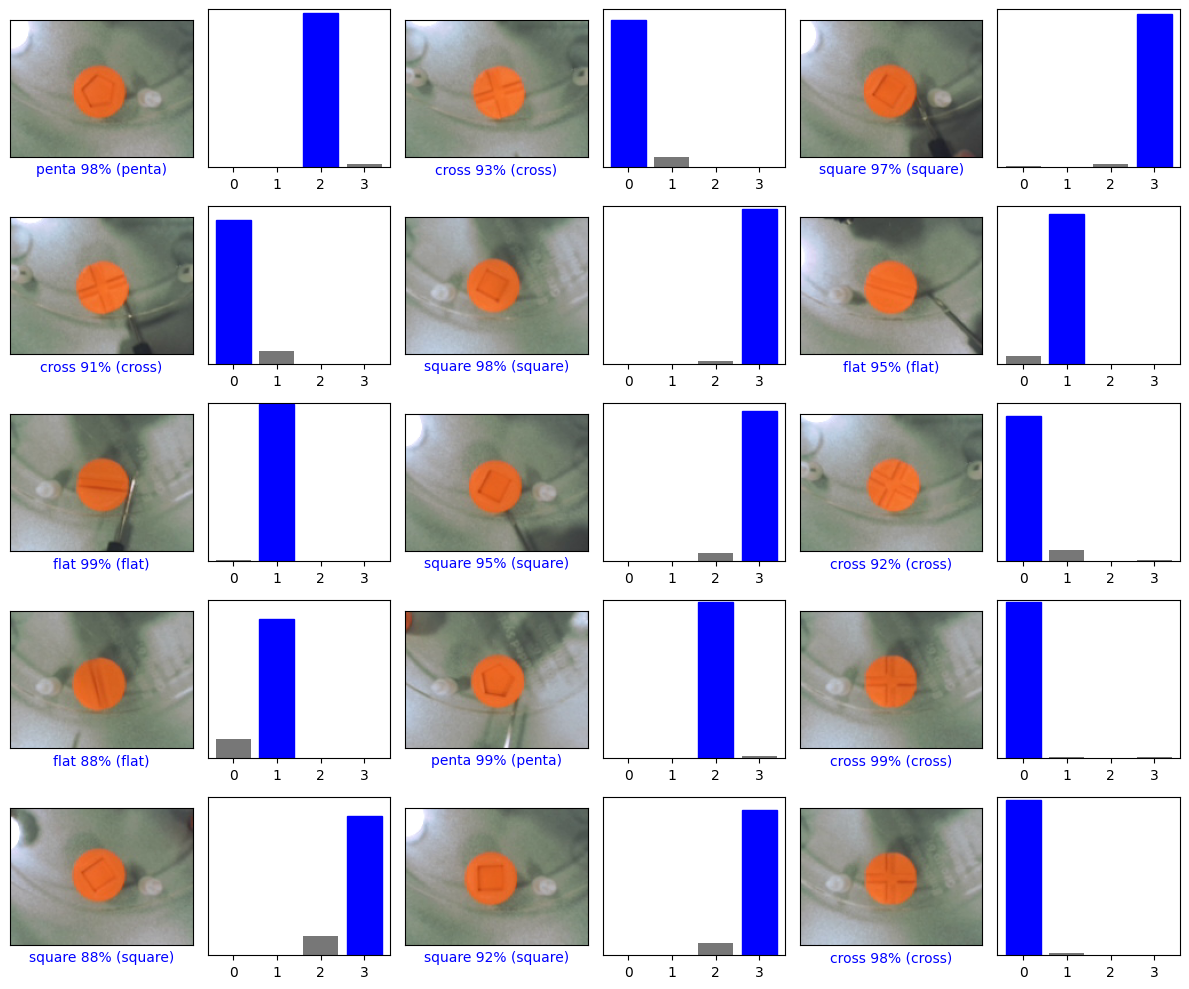

In [27]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(len(class_names)))
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

image_array = []
label_array = []
for images, labels in val_ds.take(1):
   for i, image in enumerate(images):
      image_array.append(images[i].numpy().astype("uint8"))
      label_array.append(labels[i])

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], label_array, image_array)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  label_array)
plt.show()

i = 20
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], label_array, image_array)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  label_array)
plt.show()

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], label_array, image_array)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], label_array)
plt.tight_layout()
plt.show()


# Save model

In [28]:
# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')

# Export weights

In [29]:
# np.savetxt("weights.txt", model.layers[1].weights[0].numpy(), delimiter=",")
# np.save("weights", model.layers[1].weights[0].numpy())
for i, layer in enumerate(model.layers[1:]):
    #print(i+1, len(model.layers[1:]))
    test = layer.weights
    print(len(test))

# file = open("weights", "a") 
# for w in range(1, len(model.layers)):
# 	if w == 1:
# 		varName = "#define layer1 const ap_fixed<32,24> layer1_weights[n_inputs][n_layer1]"
# 	else:
# 		varName = "#define layer" + str(w) + " const ap_fixed<32,24> layer" + str(w) + "_weights[n_layer" + str(w-1) + "][n_layer" + str(w) + "]"
# 	file.write(varName + " = ")
# 	file.write('{')
# 	print(len(model.layers), w)
# 	weights = model.layers[w].weights[0].numpy()
# 	for i in range(weights.shape[0]):
# 		file.write('{')
# 		for j in range(weights.shape[1]):
# 			file.write(str(weights[i][j]))
# 			if j != weights.shape[1]-1:
# 				file.write(', ')
# 		file.write('}')
# 		if i != weights.shape[0]-1:
# 			file.write(', ')
# 	file.write('};\n\n')

# file.close()

0
2
0
2
0
2
0
0
2
2
2
2
